In [1]:
import wandb
import torch
import yaml
from ecallisto_model import (
    ResNet,
)
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from tqdm import tqdm
import os
import pandas as pd
from ecallisto_dataset import (
    EcallistoDatasetBinary,
    custom_resize,
    remove_background,
)


/home/vincenzo/miniconda3/envs/flaresense-v2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
checkpoint_reference = "vincenzo-timmel/FlareSense-v2/best_model:v391"
CONFIG_PATH = "configs/relabel_test_only.yml"

In [3]:
api = wandb.Api()
artifact = api.artifact(checkpoint_reference)
artifact_dir = artifact.download()

wandb: Downloading large artifact best_model:v391, 128.04MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5


In [4]:
with open(CONFIG_PATH, "r") as file:
    config = yaml.safe_load(file)

In [5]:
def load_model(checkpoint_path, config, device):
    # Initialize the model
    model = ResNet(
        1,
        resnet_type=config["model"]["model_type"],
        optimizer_name="adam",
        learning_rate=1000,
        weight_decay=1, 
        label_smoothing=0.0,
    ) 

    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["state_dict"])

    return model

model = load_model(artifact.file(), config, "cpu")

In [9]:
# Transforms
resize_func = Compose(
    [
        lambda x: custom_resize(x, tuple(config["model"]["input_size"])),
    ]
)


from datasets import DatasetDict, load_dataset

def prepare_datasets(config):
    ds_train = load_dataset(config["data"]["train_path"], split=config['data']['train_split'])
    ds_valid = load_dataset(config["data"]["val_path"], split=config['data']['train_split'])
    ds_test = load_dataset(config["data"]["test_path"], split=config['data']['test_split'])

    dd = DatasetDict()
    dd["train"] = ds_train
    dd["test"] = ds_test
    dd["validation"] = ds_valid
    return dd


def prepare_dataloaders(ds_train, ds_valid, ds_test, batch_size):
    train_dataloader = DataLoader(
        ds_train, batch_size=batch_size, shuffle=False, persistent_workers=False
    )
    val_dataloader = DataLoader(
        ds_valid, batch_size=batch_size, shuffle=False, persistent_workers=False
    )
    test_dataloader = DataLoader(
        ds_test, batch_size=batch_size, shuffle=False, persistent_workers=False
    )
    return train_dataloader, val_dataloader, test_dataloader

In [10]:
dd = prepare_datasets(config)

Using the latest cached version of the dataset since i4ds/radio-sunburst-ecallisto-paths-df-v2-TEST-SET-SPLIT couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/vincenzo/.cache/huggingface/datasets/i4ds___radio-sunburst-ecallisto-paths-df-v2-test-set-split/default/0.0.0/9e8d67433b790254139be346d49129b8b81bd51d (last modified on Mon Oct 14 15:20:16 2024).
Using the latest cached version of the dataset since i4ds/radio-sunburst-ecallisto-paths-df-v2-TEST-SET-SPLIT couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/vincenzo/.cache/huggingface/datasets/i4ds___radio-sunburst-ecallisto-paths-df-v2-test-set-split/default/0.0.0/9e8d67433b790254139be346d49129b8b81bd51d (last modified on Mon Oct 14 15:20:16 2024).
Using the latest cached version of the dataset since i4ds/radio-sunburst-ecallisto-paths-df-v2-TEST-SET-SPLIT couldn't be found on the Hugging Face Hub
Found the latest cache

In [11]:
t_dl, val_dl, test_dl = prepare_dataloaders(
    EcallistoDatasetBinary(dd["train"], resize_func=resize_func, normalization_transform=remove_background, cache=False),
    EcallistoDatasetBinary(dd["validation"], resize_func=resize_func, normalization_transform=remove_background, cache=False),
    EcallistoDatasetBinary(dd["test"], resize_func=resize_func, normalization_transform=remove_background, cache=False),
    32
)

In [12]:
dd['train'][0]

{'file_path': '/mnt/nas05/data01/vincenzo/ecallisto/data/GLASGOW_01/0/2023-06-12_17-06-00.parquet',
 'label': False,
 'antenna': 'GLASGOW_01',
 'datetime': Timestamp('2023-06-12 17:06:00')}

In [13]:
def extract_Features(model, dataloader, device):
    model.eval()
    model.to(device)
    features_list = []
    # Dictionary to store the features
    features_dict = {}
    meta_data = {'label': [], 'antenna': [], 'datetime': [], 'image': []}

    # Define a hook function to capture the features
    def hook_fn(module, input, output):
        features_dict['features'] = output

    # Register the hook on the avgpool layer
    hook_handle = model.resnet.avgpool.register_forward_hook(hook_fn)

    with torch.no_grad():
        for inputs, labels, antennas, datetimes in tqdm(dataloader):
            inputs = inputs.to(device)
            _ = model(inputs)  # Forward pass
            features = features_dict['features']
            features = torch.flatten(features, 1)
            features_list.append(features.cpu())
            meta_data['label'].extend(labels.cpu().numpy())
            meta_data['antenna'].extend(list(antennas))
            meta_data['datetime'].extend(list(datetimes))
            meta_data['image'].extend(inputs.cpu().numpy())
            if len(features_list) > 50:
                break

    # Remove the hook
    hook_handle.remove()

    return features_list, meta_data

In [14]:
features_list, meta_data = extract_Features(model, test_dl, "cpu")

  0%|          | 0/191 [00:00<?, ?it/s]

 26%|██▌       | 50/191 [02:36<07:21,  3.13s/it]


In [15]:
import numpy as np
# Convert list of tensors to a single tensor
features_tensor = torch.cat(features_list, dim=0)

# Convert tensors to NumPy arrays
features_np = features_tensor.numpy()
labels_np = np.array(meta_data['label'])

In [134]:
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_np)

from sklearn.decomposition import PCA
pca = PCA(n_components=5)  # Adjust based on explained variance
pca_fit = pca.fit(features_scaled)
features_reduced = pca_fit.transform(features_scaled)


In [135]:
pca_fit.explained_variance_

array([104.11283 ,  35.022045,  30.01468 ,  21.857286,  16.23502 ],
      dtype=float32)

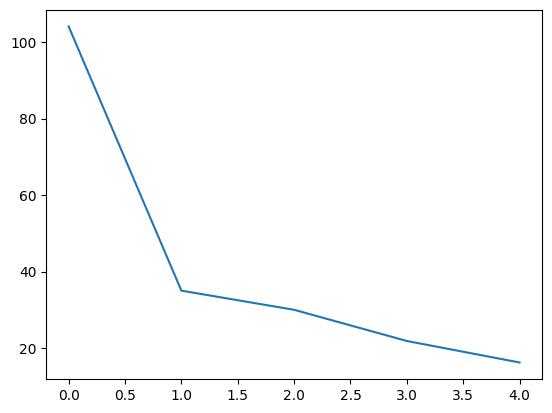

In [136]:
pca_fit.explained_variance_ratio_.cumsum()

# Plot curve
plt.plot(pca_fit.explained_variance_[:20])

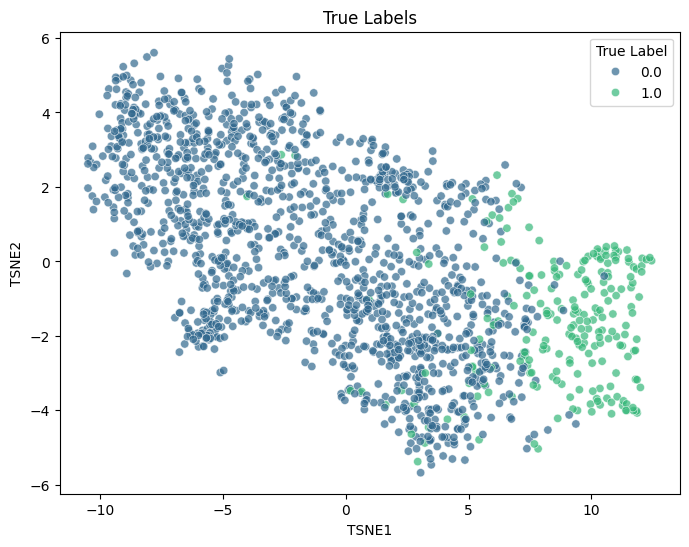

In [173]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# Reduce to 2D
tsne_3d = TSNE(n_components=3, perplexity=100)
features_3d = tsne_3d.fit_transform(features_reduced)

import seaborn as sns
import pandas as pd

# Create a DataFrame for easier plotting
df = pd.DataFrame({
    'TSNE1': features_3d[:, 0],
    'TSNE2': features_3d[:, 1],
    'TSNE3': features_3d[:, 2],
    'True Label': labels_np.squeeze(),
    'idx': range(len(features_3d)),
    'antenna': meta_data['antenna']
})

# Plot true labels
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='True Label', palette='viridis', alpha=0.7)
plt.title('True Labels')
plt.show()



In [175]:
import plotly.express as px
import plotly.io as pio

# Create 3D scatter plot with enhanced aesthetics
fig = px.scatter_3d(
    df,
    x='TSNE1',
    y='TSNE2',
    z='TSNE3',
    color='True Label',
    hover_data=['idx', 'antenna'],
    title='Enhanced 3D Scatter Plot',
    labels={
        'TSNE1': 't-SNE Component 1',
        'TSNE2': 't-SNE Component 2',
        'TSNE3': 't-SNE Component 3',
        'True Label': 'True Label',
    }
)

# Update marker properties for better aesthetics
fig.update_traces(
    marker=dict(
        size=5,          # Adjust marker size
        opacity=0.8,     # Set opacity for transparency
        symbol='circle', # Marker symbol
        line=dict(width=0.5, color='DarkSlateGrey')  # Border around markers
    )
)

# Customize the layout
fig.update_layout(
    scene=dict(
        xaxis=dict(title='t-SNE 1', backgroundcolor="rgb(200, 200, 230)"),
        yaxis=dict(title='t-SNE 2', backgroundcolor="rgb(230, 200,230)"),
        zaxis=dict(title='t-SNE 3', backgroundcolor="rgb(230, 230,200)"),
        camera=dict(
            eye=dict(x=1.25, y=1.25, z=1.25)  # Adjust camera angle
        )
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    legend=dict(
        title='True Label',
        x=0.85,
        y=0.95
    )
)

# Optionally, adjust the background of the entire plot
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white'
)

pio.write_html(fig, file="plot_3d_tsne.html")

In [177]:
meta_data['antenna'][774]

'ALASKA-HAARP_62'

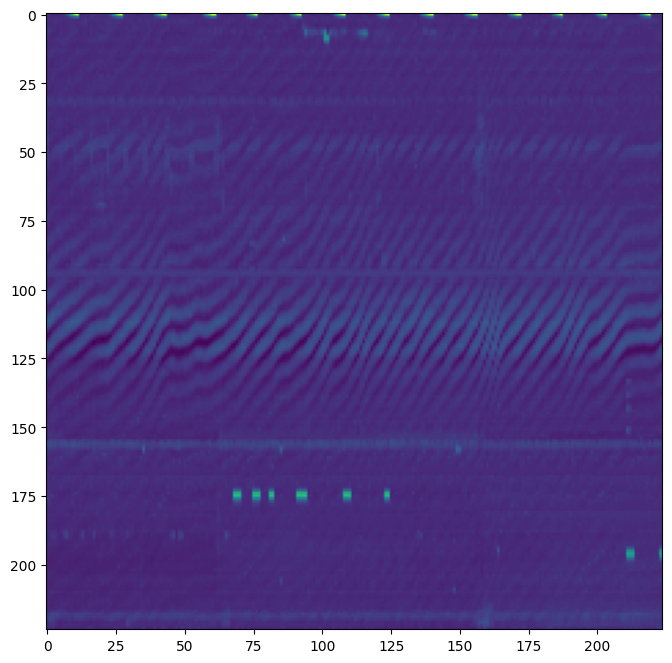

In [197]:
plt.figure(figsize=(8, 8))
plt.imshow(meta_data['image'][1456].squeeze())

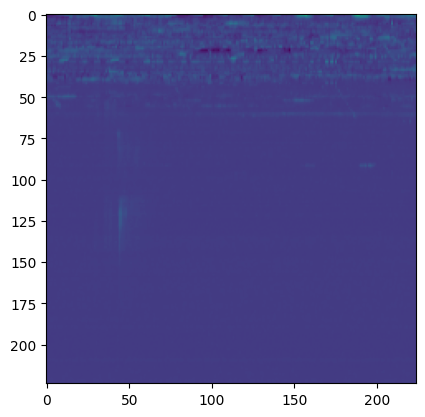

In [108]:
plt.imshow(meta_data['image'][5].squeeze())

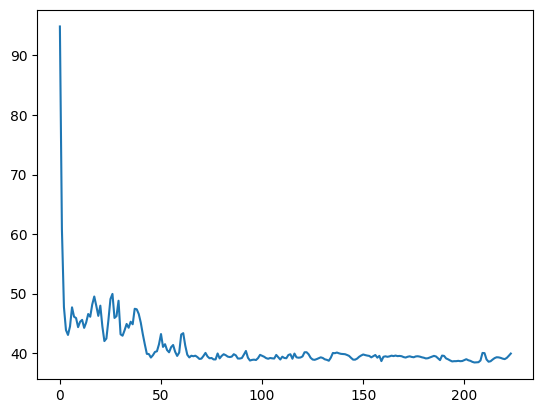

In [109]:
plt.plot(meta_data['image'][5].squeeze().sum(axis=1))

In [110]:
from scipy.stats import spearmanr

In [111]:
np.std(meta_data['image'][5].squeeze(), axis=1).std()

0.0239956

Axis 0: Über die Zeit 
Axis 1: Über die Frequenzen

In [112]:
meanstd = [np.std(x.squeeze(), axis=0).mean() for x in meta_data['image']]
spearmanr(features_2d[:, 0], meanstd)

SignificanceResult(statistic=0.20990647296399273, pvalue=1.044379040345176e-17)

In [113]:
stdmax = [np.max(x.squeeze(), axis=0).std() for x in meta_data['image']]
spearmanr(features_2d[:, 0], stdmax)

SignificanceResult(statistic=-0.11633868334094884, pvalue=2.4498409293110275e-06)

In [114]:
maxmax = [np.max(x.squeeze(), axis=0).mean() for x in meta_data['image']]
spearmanr(features_2d[:, 0], maxmax)

SignificanceResult(statistic=0.08209412286369833, pvalue=0.0009017778460311558)

In [115]:
minmin = [np.min(x.squeeze(), axis=1).mean() for x in meta_data['image']]
spearmanr(features_2d[:, 0], minmin)

SignificanceResult(statistic=0.003242692491844473, pvalue=0.89585573709995)

In [116]:
stdmin = [np.min(x.squeeze(), axis=1).std() for x in meta_data['image']]
spearmanr(features_2d[:, 0], stdmin)

SignificanceResult(statistic=0.12400561398312049, pvalue=5.030400469253062e-07)

In [117]:
sumsum = [np.sum(x.squeeze(), axis=0).sum() for x in meta_data['image']]
spearmanr(features_2d[:, 0], sumsum)

SignificanceResult(statistic=0.06989620289821206, pvalue=0.004728650197570081)

In [118]:
spearmanr(minmin, maxmax)

SignificanceResult(statistic=0.8787141970844197, pvalue=0.0)

In [119]:
spearmanr(stdstd, stdmax)

SignificanceResult(statistic=-0.7509184112501315, pvalue=5.013299601803183e-296)

In [120]:
spearmanr(stdstd, stdmin)

SignificanceResult(statistic=0.6511334065886156, pvalue=1.744259862863354e-197)

In [121]:
spearmanr(stdmax, stdmin)

SignificanceResult(statistic=-0.8416267364789375, pvalue=0.0)

In [122]:
spearmanr(stdstd, sumsum)

SignificanceResult(statistic=0.5777843161843634, pvalue=5.659937004485144e-146)

In [123]:
np.corrcoef(features_2d[:, 0], sum_intensity)

NameError: name 'sum_intensity' is not defined

In [171]:
meta_data['image'][0].shape

(1, 224, 224)

In [147]:
from sklearn.metrics import normalized_mutual_info_score

nmi = normalized_mutual_info_score(labels_np.squeeze(), cluster_labels)
print(f'Normalized Mutual Information: {nmi}')


Normalized Mutual Information: 0.21286951888571512
